<a href="https://colab.research.google.com/github/nekotanku/colab/blob/master/pytorch_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch 
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import  DataLoader

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cuda'

In [26]:
#前処理
transform = transforms.Compose([
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, ), (0.5,))
])
#訓練用データセット
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
names = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

In [6]:
#Dataloader
train_dataloader  = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [7]:
data_iter = iter(train_dataloader)

In [8]:
imgs, labels =  data_iter.next()

In [9]:
labels

tensor([0, 2, 8, 3, 1, 9, 6, 6, 5, 9, 4, 5, 4, 2, 3, 9, 8, 3, 8, 6, 9, 5, 6, 7,
        9, 3, 8, 0, 2, 1, 8, 6])

In [10]:
#(ミニバッチ, channel, H, W)
imgs.size()

torch.Size([32, 3, 32, 32])

In [11]:
img = imgs[0]


In [12]:
#channel Lastに変換
img_permute = img.permute(1,2,0)

In [13]:
img_permute  = 0.5 * img_permute + 0.5

In [14]:
img_permute = np.clip(img_permute, 0, 1)

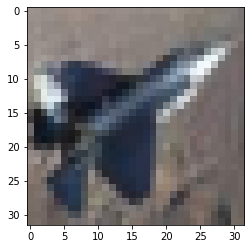

In [15]:
plt.imshow(img_permute)

In [17]:
labels

tensor([0, 2, 8, 3, 1, 9, 6, 6, 5, 9, 4, 5, 4, 2, 3, 9, 8, 3, 8, 6, 9, 5, 6, 7,
        9, 3, 8, 0, 2, 1, 8, 6])

In [20]:
#CNN定義
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.featuers = nn.Sequential(#初期　32*32
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),#16*16
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), #8*8
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),#4*4
            #絞る
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Linear(in_features=4 * 4 * 128, out_features=num_classes
    )
    
    def forward(self, x):
        x = self.featuers(x)
        #1次元配列に直すx.size(0)=バッチ数、それ以外は適当に振り分け
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [21]:
model = CNN(10)
model.to(device)

CNN(
  (featuers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

In [28]:
num_epochs =15
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    #train_loop
    running_loss = 0.0
    running_acc = 0.0
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)
    
    
    #validation_loop
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)
    print("epoch:{}, loss: {}, acc:{}, val_loss:{}, val_acc:{}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc) )


epoch:0, loss: 1.359012867118484, acc:0.5073776245117188, val_loss:1.036692264933175, val_acc:0.6352835297584534
epoch:1, loss: 0.8971341027713173, acc:0.6872400641441345, val_loss:0.8319218696687168, val_acc:0.7116613388061523
epoch:2, loss: 0.7239362842767421, acc:0.7460013031959534, val_loss:0.7801608093820822, val_acc:0.7223442196846008
epoch:3, loss: 0.6244277809189438, acc:0.7810500860214233, val_loss:0.7638548730661313, val_acc:0.7376198172569275
epoch:4, loss: 0.5443627525142425, acc:0.8100208044052124, val_loss:0.7192555067543024, val_acc:0.7584863901138306
epoch:5, loss: 0.48935172067608346, acc:0.8293746113777161, val_loss:0.7103816787846172, val_acc:0.7581868767738342
epoch:6, loss: 0.42885910976089425, acc:0.8485284447669983, val_loss:0.732339703332121, val_acc:0.7623801827430725
epoch:7, loss: 0.3887361312238589, acc:0.8638235926628113, val_loss:0.7210368189377526, val_acc:0.7658745646476746
epoch:8, loss: 0.3512942151941707, acc:0.8758997321128845, val_loss:0.74990454247

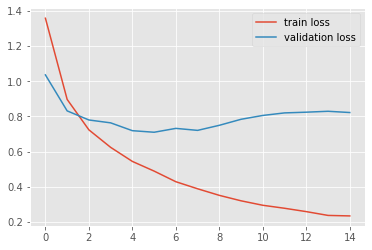

In [33]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.legend()

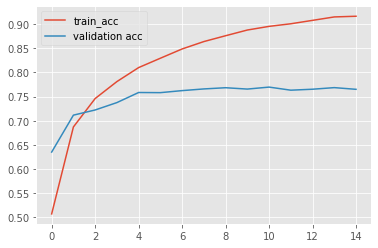

In [30]:
plt.plot(accs, label="train_acc")
plt.plot(val_accs, label="validation acc")
plt.legend()

#過学習した！！！
